In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

In [2]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [3]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [4]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'augmented', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['augmented', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [5]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for augmented data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [6]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [7]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [8]:
X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]


y_test  =org_test_processed[target]
X_test = org_test_processed[features].copy()
X_test.index = pd.to_datetime(org_test_processed["Time"])

In [9]:
import torch
import torch.nn as nn
import numpy as np

# ------------------ TimesNet Model ------------------

class TimesBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), dilation=(1, dilation), padding=(0, dilation * (kernel_size - 1) // 2))
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.norm(out)
        out = self.relu(out)
        return out

class TimesNet(nn.Module):
    def __init__(self, input_len, forecast_len, num_features, hidden_channels=64, num_blocks=3, kernel_size=3):
        super().__init__()
        self.input_len = input_len
        self.forecast_len = forecast_len
        self.num_features = num_features

        self.blocks = nn.ModuleList()
        in_channels = 1

        for i in range(num_blocks):
            block = TimesBlock(in_channels, hidden_channels, kernel_size, dilation=2**i)
            self.blocks.append(block)
            in_channels = hidden_channels

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(hidden_channels, forecast_len)

    def forward(self, x):
        # Input shape: [Batch, Seq_len, Num_features]
        x = x.unsqueeze(1)  # [Batch, 1, Seq_len, Num_features] -> like an image
        for block in self.blocks:
            x = block(x)
        x = self.global_pool(x).squeeze(-1).squeeze(-1)
        out = self.fc(x)
        return out


In [10]:
# ------------------ Sequence Creation ------------------

def create_timesnet_multivariate_sequences(X_data, y_data, input_len, forecast_len):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - input_len - forecast_len + 1):
        X_seq.append(X_data[i:i+input_len])
        y_seq.append(y_data[i+input_len:i+input_len+forecast_len])
    return np.array(X_seq), np.array(y_seq)


In [11]:
# Desequencing Function
def desequence_forecasts(predictions, input_len, forecast_len):
    total_length = len(predictions) + input_len + forecast_len - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)

    for i in range(len(predictions)):
        start = i + input_len
        end = start + forecast_len
        merged_forecast[start:end] += predictions[i]
        count[start:end] += 1

    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]
    return merged_forecast


In [12]:
input_len = 24
forecast_len = 12
num_features = X_train_org.shape[1]


In [13]:
model_timesnet_org = TimesNet(input_len=input_len, forecast_len=forecast_len, num_features=num_features)
model_timesnet_aug = TimesNet(input_len=input_len, forecast_len=forecast_len, num_features=num_features)


In [14]:
# Load checkpoint
checkpoint_org = torch.load("../Models/weights/timesnet_org_shuffle.pth")
checkpoint_aug = torch.load("../Models/weights/timesnet_aug_shuffle.pth")

# Extract only the model state
model_timesnet_org.load_state_dict(checkpoint_org['model_state'])
model_timesnet_aug.load_state_dict(checkpoint_aug['model_state'])

<All keys matched successfully>

In [15]:
# ------------------ Desequencing ------------------

def desequence_forecasts(predictions, input_len, forecast_len):
    total_length = len(predictions) + input_len + forecast_len - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)

    for i in range(len(predictions)):
        start = i + input_len
        end = start + forecast_len
        merged_forecast[start:end] += predictions[i]
        count[start:end] += 1

    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]
    return merged_forecast

# ------------------ Evaluation ------------------

import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_timesnet_multivariate(model, scaler_X, scaler_y, X_test, y_test, input_len, forecast_len, time_index=None, start_point=0, end_point=None):
    X_test = X_test[start_point:end_point]
    y_test = y_test[start_point:end_point]

    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    X_seq, y_seq = create_timesnet_multivariate_sequences(X_test_scaled, y_test_scaled, input_len, forecast_len)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        preds_scaled = model(X_tensor).numpy()

    preds = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1)).reshape(preds_scaled.shape)
    y_true = scaler_y.inverse_transform(y_seq.reshape(-1, 1)).reshape(y_seq.shape)

    merged_pred = desequence_forecasts(preds, input_len, forecast_len)
    merged_true = desequence_forecasts(y_true, input_len, forecast_len)

    merged_pred = merged_pred
    merged_true = merged_true

    mse = mean_squared_error(merged_true, merged_pred)
    mae = mean_absolute_error(merged_true, merged_pred)
    rmse = math.sqrt(mse)
    print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    if time_index is not None:
        valid_time_index = time_index[input_len+forecast_len:][:len(merged_pred)]
    else:
        valid_time_index = range(len(merged_pred))

    plt.figure(figsize=(16, 6))
    plt.plot(valid_time_index, merged_true, label="Actual", color="black")
    plt.plot(valid_time_index, merged_pred, label="Forecast", color="red", linestyle="--")
    plt.xlabel("Time" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title("TimesNet Forecast vs Actual")
    plt.legend()
    plt.grid(True)
    textstr = f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}'
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()


In [16]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import torch
import numpy as np
import math

def evaluate_two_timesnet_models(
    model_org, model_aug,
    X_train_org, y_train_org,
    X_test, y_test,
    input_len, forecast_len,
    start_point=0, end_point=None
):
    # ----------------- Step 1: Scaling -----------------
    scaler_X = StandardScaler()
    scaler_X.fit(X_train_org)

    scaler_y = StandardScaler()
    scaler_y.fit(y_train_org.values.reshape(-1, 1))

    # ----------------- Step 2: Slice test set -----------------
    X_test = X_test[start_point:end_point].reset_index(drop=True)
    y_test = y_test[start_point:end_point].reset_index(drop=True)

    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    # ----------------- Step 3: Sequence creation -----------------
    X_seq, y_seq = create_timesnet_multivariate_sequences(X_test_scaled, y_test_scaled, input_len, forecast_len)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)

    # ----------------- Step 4: Prediction -----------------
    model_org.eval()
    model_aug.eval()
    with torch.no_grad():
        preds_org_scaled = model_org(X_tensor).numpy()
        preds_aug_scaled = model_aug(X_tensor).numpy()

    # ----------------- Step 5: Inverse scale predictions and targets -----------------
    preds_org = scaler_y.inverse_transform(preds_org_scaled.reshape(-1, 1)).reshape(preds_org_scaled.shape)
    preds_aug = scaler_y.inverse_transform(preds_aug_scaled.reshape(-1, 1)).reshape(preds_aug_scaled.shape)
    y_true = scaler_y.inverse_transform(y_seq.reshape(-1, 1)).reshape(y_seq.shape)

    # ----------------- Step 6: Desequencing -----------------
    merged_pred_org = desequence_forecasts(preds_org, input_len, forecast_len)
    merged_pred_aug = desequence_forecasts(preds_aug, input_len, forecast_len)
    merged_true = desequence_forecasts(y_true, input_len, forecast_len)

    # Align lengths
    min_len = min(len(merged_pred_org), len(merged_pred_aug), len(merged_true))
    merged_pred_org = merged_pred_org[:min_len]
    merged_pred_aug = merged_pred_aug[:min_len]
    merged_true = merged_true[:min_len]

    # ----------------- Step 7: Metrics -----------------
    mse_org = mean_squared_error(merged_true, merged_pred_org)
    mae_org = mean_absolute_error(merged_true, merged_pred_org)
    rmse_org = math.sqrt(mse_org)

    mse_aug = mean_squared_error(merged_true, merged_pred_aug)
    mae_aug = mean_absolute_error(merged_true, merged_pred_aug)
    rmse_aug = math.sqrt(mse_aug)

    print(f"[Original]  MAE: {mae_org:.4f}, RMSE: {rmse_org:.4f}")
    print(f"[Augmented] MAE: {mae_aug:.4f}, RMSE: {rmse_aug:.4f}")

    # ----------------- Step 8: Plotting -----------------
    plot_range = range(min_len)

    plt.figure(figsize=(16, 6))
    plt.plot(plot_range, merged_true, label='Actual', color='black')
    plt.plot(plot_range, merged_pred_org, label='Original Forecast', color='red', linestyle='--')
    plt.plot(plot_range, merged_pred_aug, label='Augmented Forecast', color='green', linestyle=':')

    # Highlight error regions
    plt.fill_between(plot_range, merged_true, merged_pred_org,
                     where=(merged_true >= merged_pred_org),
                     interpolate=True, color='pink', alpha=0.3, label='Error (Orig)')
    plt.fill_between(plot_range, merged_pred_org, merged_true,
                     where=(merged_true < merged_pred_org),
                     interpolate=True, color='pink', alpha=0.3)

    plt.fill_between(plot_range, merged_pred_org, merged_pred_aug,
                     where=(merged_pred_aug >= merged_pred_org),
                     interpolate=True, color='lightblue', alpha=0.3, label='(Aug - Orig )Diff')
    plt.fill_between(plot_range, merged_pred_aug, merged_pred_org,
                     where=(merged_pred_aug < merged_pred_org),
                     interpolate=True, color='lightblue', alpha=0.3)

    plt.xlabel("Steps")
    plt.ylabel("Power")
    plt.title("TimesNet Forecast Comparison: Original vs Augmented")
    plt.legend()
    plt.grid(True)

    textstr = (
        f'Original Model\nMAE: {mae_org:.4f}\nRMSE: {rmse_org:.4f}\n'
        f'Augmented Model\nMAE: {mae_aug:.4f}\nRMSE: {rmse_aug:.4f}'
    )
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    # plt.show()

    #     # --- Inset Zoom Plot ---
    # # Define zoom window (adjust indices for a peak region)
    # zoom_start, zoom_end = 200, 300

    # ax_main = plt.gca()
    # ax_inset = inset_axes(ax_main, width="30%", height="40%", loc='upper left', borderpad=3)
    # ax_inset.plot(range(zoom_start, zoom_end), merged_true[zoom_start:zoom_end], color='black')
    # ax_inset.plot(range(zoom_start, zoom_end), merged_pred_org[zoom_start:zoom_end], color='red', linestyle='--')
    # ax_inset.plot(range(zoom_start, zoom_end), merged_pred_aug[zoom_start:zoom_end], color='green', linestyle=':')

    # ax_inset.set_title("Zoomed-In View")
    # ax_inset.grid(True)
    # ax_inset.tick_params(axis='both', labelsize=8)

    # mark_inset(ax_main, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")

    plt.show()

    return {
        'Original': {'MAE': mae_org, 'RMSE': rmse_org},
        'Augmented': {'MAE': mae_aug, 'RMSE': rmse_aug}
    }


[Original]  MAE: 0.2465, RMSE: 0.3036
[Augmented] MAE: 0.2685, RMSE: 0.3270


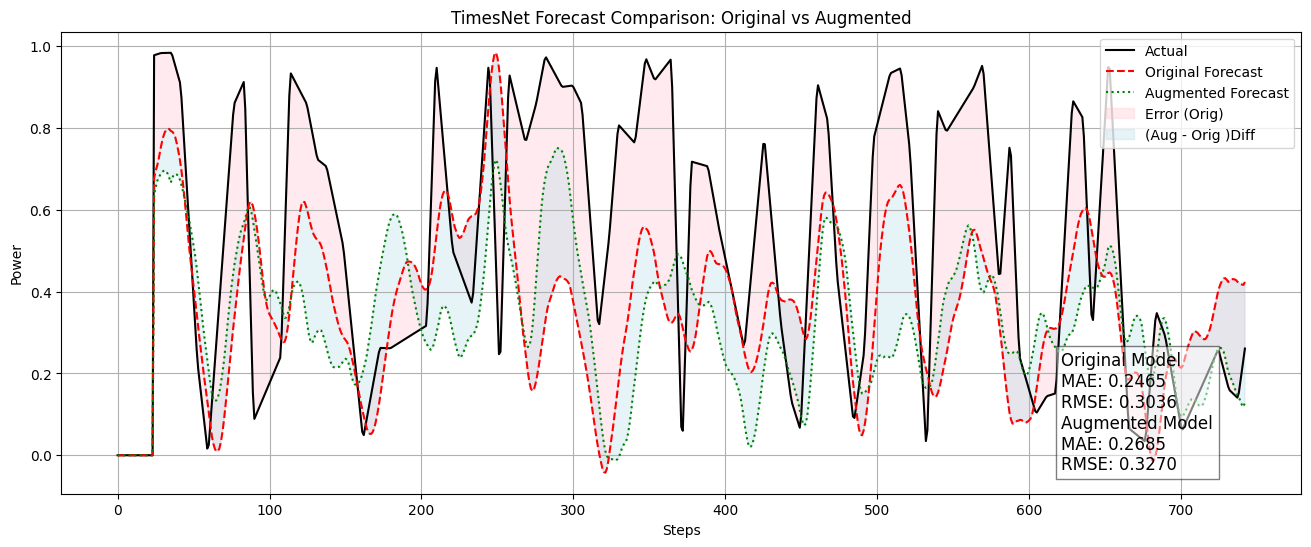

[Original]  MAE: 0.1405, RMSE: 0.1876
[Augmented] MAE: 0.1412, RMSE: 0.1884


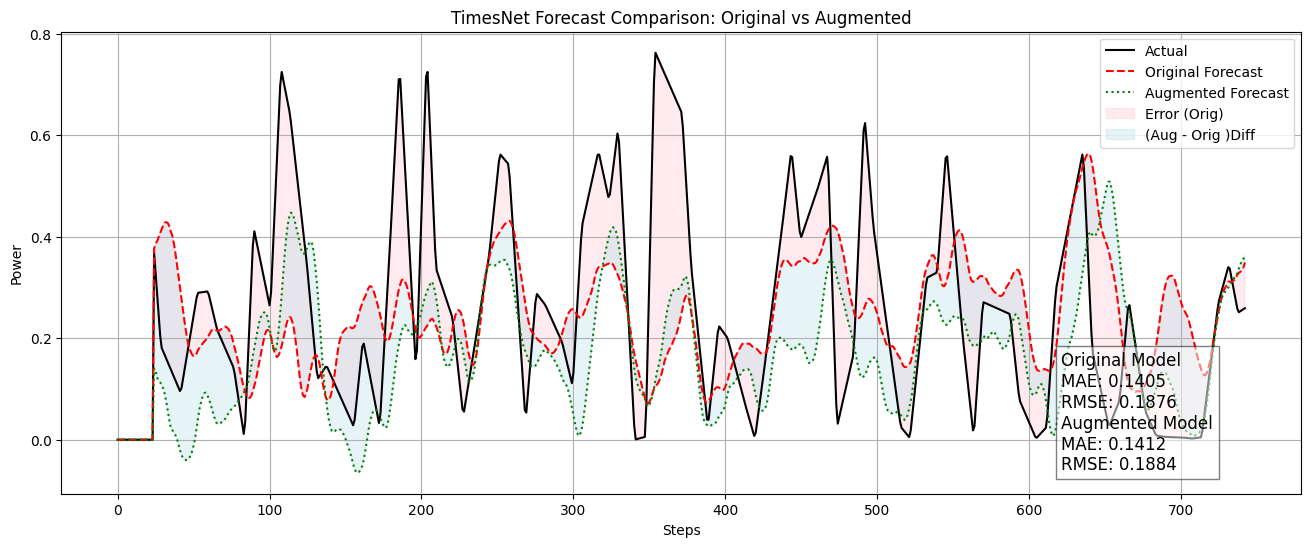

[Original]  MAE: 0.2940, RMSE: 0.3598
[Augmented] MAE: 0.3081, RMSE: 0.3638


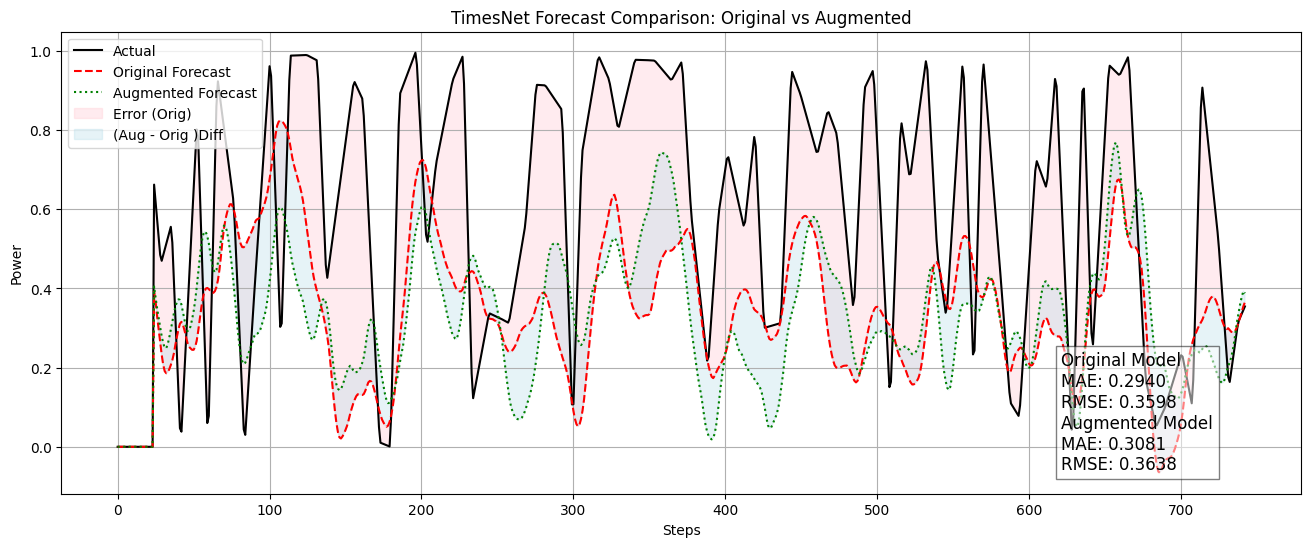

[Original]  MAE: 0.1750, RMSE: 0.2134
[Augmented] MAE: 0.1846, RMSE: 0.2431


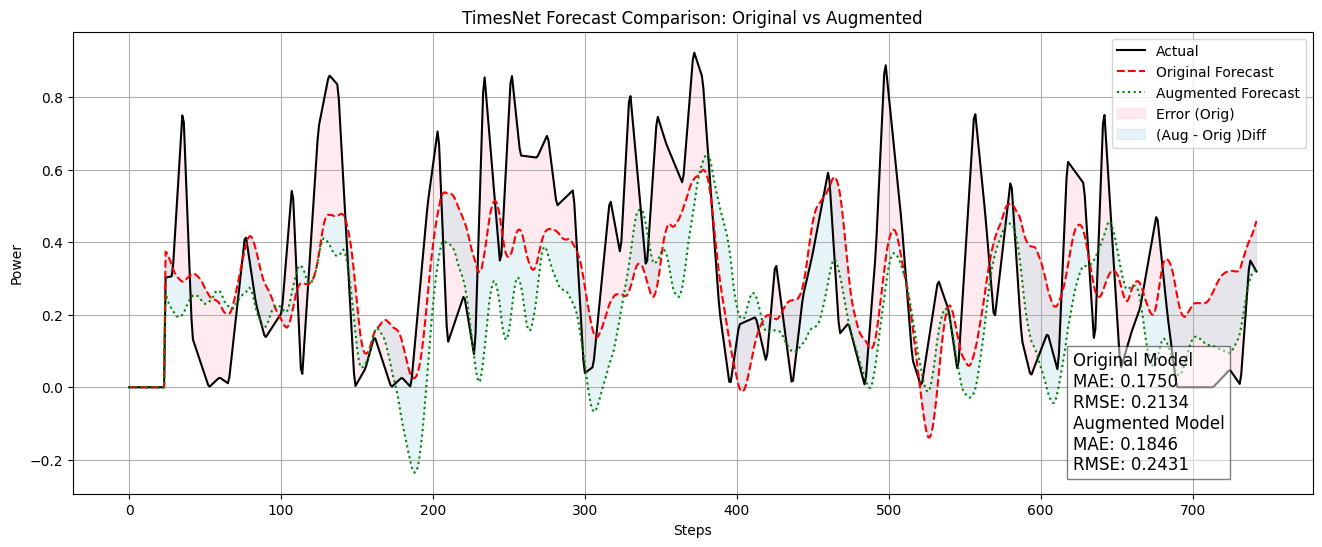

In [20]:
results = evaluate_two_timesnet_models(
    model_org=model_timesnet_org,
    model_aug=model_timesnet_aug,
    X_train_org=X_train_org,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    input_len=24,
    forecast_len=12,
    start_point=7991, 
    end_point=8734
)

results_1 = evaluate_two_timesnet_models(
    model_org=model_timesnet_org,
    model_aug=model_timesnet_aug,
    X_train_org=X_train_org,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    input_len=24,
    forecast_len=12,
   start_point=16726, 
   end_point=17469
)

results_2 = evaluate_two_timesnet_models(
    model_org=model_timesnet_org,
    model_aug=model_timesnet_aug,
    X_train_org=X_train_org,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    input_len=24,
    forecast_len=12,
    start_point=25461, 
    end_point=26204
)

results_3 = evaluate_two_timesnet_models(
    model_org=model_timesnet_org,
    model_aug=model_timesnet_aug,
    X_train_org=X_train_org,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    input_len=24,
    forecast_len=12,
    start_point=34196, 
    end_point=34939
)

In [138]:
org_test_processed

,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power,...,windspeed_10m_roll_mean_24,windspeed_10m_roll_std_24,windspeed_100m_roll_mean_24,windspeed_100m_roll_std_24,windgusts_10m_roll_mean_24,windgusts_10m_roll_std_24,hour_sin,hour_cos,month_sin,month_cos
0,2021-01-02 01:00:00,31.6,97,30.9,0.178920,0.229551,350,5,0.167247,0.525315,...,0.218597,0.201177,0.283829,0.214600,0.243010,0.343641,0.629410,0.982963,0.75,0.933013
1,2021-01-02 02:00:00,31.9,97,31.1,0.242030,0.297713,336,344,0.226481,0.503502,...,0.226400,0.183876,0.294146,0.192060,0.251839,0.322168,0.750000,0.933013,0.75,0.933013
2,2021-01-02 03:00:00,32.3,95,31.2,0.241379,0.307388,346,351,0.268293,0.481689,...,0.232329,0.172854,0.302148,0.181658,0.262771,0.300694,0.853553,0.853553,0.75,0.933013
3,2021-01-02 04:00:00,32.1,97,31.3,0.256344,0.321020,336,341,0.278746,0.459876,...,0.239367,0.159353,0.310794,0.170785,0.273912,0.277790,0.933013,0.750000,0.75,0.933013
4,2021-01-02 05:00:00,32.3,97,31.7,0.224463,0.289358,338,343,0.247387,0.439764,...,0.244530,0.143031,0.317870,0.152677,0.284003,0.242641,0.982963,0.629410,0.75,0.933013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34935,2021-12-31 19:00:00,25.5,94,24.0,0.260898,0.288478,4,8,0.268293,0.341905,...,0.166386,0.217855,0.199974,0.277100,0.161026,0.213027,0.017037,0.629410,0.50,1.000000
34936,2021-12-31 20:00:00,25.3,92,23.2,0.305791,0.326297,1,5,0.257840,0.334401,...,0.173195,0.234004,0.204400,0.289721,0.167753,0.223452,0.066987,0.750000,0.50,1.000000
34937,2021-12-31 21:00:00,24.9,90,22.5,0.299935,0.328496,4,8,0.257840,0.326896,...,0.180041,0.246608,0.209289,0.302381,0.173849,0.232776,0.146447,0.853553,0.50,1.000000
34938,2021-12-31 22:00:00,24.9,89,22.1,0.299284,0.322779,2,6,0.254355,0.319392,...,0.183790,0.256219,0.211681,0.309337,0.177633,0.240453,0.250000,0.933013,0.50,1.000000


In [139]:
org_test_processed.iloc[len(org_test_processed)//4: (len(org_test_processed)//4)*2]

,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power,...,windspeed_10m_roll_mean_24,windspeed_10m_roll_std_24,windspeed_100m_roll_mean_24,windspeed_100m_roll_std_24,windgusts_10m_roll_mean_24,windgusts_10m_roll_std_24,hour_sin,hour_cos,month_sin,month_cos
8735,2021-01-02 01:00:00,27.3,76,20.8,0.324008,0.430959,248,247,0.271777,0.238643,...,0.223646,0.224829,0.334748,0.352209,0.211268,0.182984,0.629410,0.982963,0.75,0.933013
8736,2021-01-02 02:00:00,27.1,76,20.5,0.314899,0.422603,240,242,0.271777,0.250350,...,0.226017,0.231139,0.337141,0.358958,0.212949,0.188057,0.750000,0.933013,0.75,0.933013
8737,2021-01-02 03:00:00,27.1,74,20.0,0.331815,0.446790,235,237,0.278746,0.262057,...,0.229995,0.241563,0.341876,0.372184,0.215892,0.195896,0.853553,0.853553,0.75,0.933013
8738,2021-01-02 04:00:00,27.7,71,19.6,0.335068,0.452067,241,241,0.289199,0.273764,...,0.233706,0.251333,0.346610,0.385223,0.219676,0.205829,0.933013,0.750000,0.75,0.933013
8739,2021-01-02 05:00:00,27.2,72,19.5,0.320104,0.438434,241,241,0.285714,0.277567,...,0.237875,0.258783,0.351782,0.396466,0.223250,0.214117,0.982963,0.629410,0.75,0.933013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17465,2021-12-31 19:00:00,-17.9,72,-24.2,0.400781,0.462621,317,317,0.317073,0.253152,...,0.372667,0.131100,0.466049,0.202854,0.320160,0.117985,0.017037,0.629410,0.50,1.000000
17466,2021-12-31 20:00:00,-18.4,72,-24.7,0.381913,0.446790,313,317,0.341463,0.255053,...,0.380967,0.119130,0.473665,0.200176,0.329620,0.104676,0.066987,0.750000,0.50,1.000000
17467,2021-12-31 21:00:00,-18.5,71,-25.1,0.409889,0.471416,312,315,0.327526,0.257054,...,0.386704,0.126988,0.479043,0.207197,0.334665,0.104800,0.146447,0.853553,0.50,1.000000
17468,2021-12-31 22:00:00,-18.7,71,-25.1,0.353936,0.419085,306,312,0.327526,0.259055,...,0.387775,0.127187,0.479583,0.207597,0.338449,0.107246,0.250000,0.933013,0.50,1.000000


In [140]:
org_test_processed.iloc[(len(org_test_processed)//4)*2: (len(org_test_processed)//4)*3]

,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power,...,windspeed_10m_roll_mean_24,windspeed_10m_roll_std_24,windspeed_100m_roll_mean_24,windspeed_100m_roll_std_24,windgusts_10m_roll_mean_24,windgusts_10m_roll_std_24,hour_sin,hour_cos,month_sin,month_cos
17470,2021-01-02 01:00:00,13.0,88,10.0,0.150943,0.264732,353,355,0.121951,0.059035,...,0.117044,0.134268,0.210781,0.223777,0.098592,0.070467,0.629410,0.982963,0.75,0.933013
17471,2021-01-02 02:00:00,16.2,87,13.1,0.145738,0.156113,333,351,0.128920,0.042125,...,0.117044,0.134268,0.205609,0.224445,0.099222,0.070422,0.750000,0.933013,0.75,0.933013
17472,2021-01-02 03:00:00,15.5,89,12.9,0.055953,0.062885,234,328,0.073171,0.025315,...,0.110159,0.147409,0.192950,0.237087,0.094808,0.076743,0.853553,0.853553,0.75,0.933013
17473,2021-01-02 04:00:00,14.2,92,12.2,0.102798,0.066403,252,300,0.048780,0.008405,...,0.109509,0.148730,0.184433,0.252692,0.089552,0.090972,0.933013,0.750000,0.75,0.933013
17474,2021-01-02 05:00:00,12.3,93,10.6,0.143136,0.095866,270,293,0.076655,0.000800,...,0.111345,0.146896,0.178901,0.260704,0.088711,0.093620,0.982963,0.629410,0.75,0.933013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26200,2021-12-31 19:00:00,14.4,58,2.1,0.456083,0.431838,2,3,0.400697,0.327697,...,0.341379,0.486990,0.391818,0.313533,0.313012,0.533948,0.017037,0.629410,0.50,1.000000
26201,2021-12-31 20:00:00,12.6,57,0.0,0.445023,0.424802,6,6,0.411150,0.336702,...,0.354881,0.491354,0.398508,0.319534,0.327728,0.537700,0.066987,0.750000,0.50,1.000000
26202,2021-12-31 21:00:00,10.3,56,-2.2,0.417046,0.391381,356,359,0.393728,0.345607,...,0.367541,0.487795,0.404143,0.319872,0.341181,0.536323,0.146447,0.853553,0.50,1.000000
26203,2021-12-31 22:00:00,8.1,55,-4.6,0.407287,0.385224,347,349,0.369338,0.354613,...,0.381158,0.476372,0.410575,0.317048,0.354005,0.527187,0.250000,0.933013,0.50,1.000000


In [141]:
X_test

,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power_lag1,Power_lag3,Power_lag6,Power_lag12,Power_lag24,...,windgusts_10m_roll_mean_12,windgusts_10m_roll_std_12,Power_roll_mean_24,Power_roll_std_24,windspeed_10m_roll_mean_24,windspeed_10m_roll_std_24,windspeed_100m_roll_mean_24,windspeed_100m_roll_std_24,windgusts_10m_roll_mean_24,windgusts_10m_roll_std_24
Time,,,,,,,,,,,,,,,,,,,,,
2021-01-02 01:00:00,0.178920,0.229551,350,5,0.167247,0.547128,0.590754,0.656194,0.646188,0.159396,...,0.300343,0.171520,0.499292,0.453115,0.218597,0.201177,0.283829,0.214600,0.243010,0.343641
2021-01-02 02:00:00,0.242030,0.297713,336,344,0.226481,0.525315,0.568941,0.634381,0.655693,0.151791,...,0.295013,0.175282,0.514067,0.420130,0.226400,0.183876,0.294146,0.192060,0.251839,0.322168
2021-01-02 03:00:00,0.241379,0.307388,346,351,0.268293,0.503502,0.547128,0.612568,0.665099,0.144287,...,0.296155,0.175668,0.528241,0.379859,0.232329,0.172854,0.302148,0.181658,0.262771,0.300694
2021-01-02 04:00:00,0.256344,0.321020,336,341,0.278746,0.481689,0.525315,0.590754,0.674605,0.136682,...,0.292349,0.164289,0.541819,0.330340,0.239367,0.159353,0.310794,0.170785,0.273912,0.277790
2021-01-02 05:00:00,0.224463,0.289358,338,343,0.247387,0.459876,0.503502,0.568941,0.684110,0.168501,...,0.286258,0.153499,0.553214,0.280673,0.244530,0.143031,0.317870,0.152677,0.284003,0.242641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,0.260898,0.288478,4,8,0.268293,0.349410,0.266360,0.092956,0.033420,0.006604,...,0.192996,0.256155,0.093242,0.265347,0.166386,0.217855,0.199974,0.277100,0.161026,0.213027
2021-12-31 20:00:00,0.305791,0.326297,1,5,0.257840,0.341905,0.324195,0.150690,0.027416,0.011007,...,0.214313,0.222553,0.106828,0.285547,0.173195,0.234004,0.204400,0.289721,0.167753,0.223452
2021-12-31 21:00:00,0.299935,0.328496,4,8,0.257840,0.334401,0.349410,0.208525,0.021313,0.015509,...,0.231443,0.196817,0.119909,0.300175,0.180041,0.246608,0.209289,0.302381,0.173849,0.232776


In [142]:
org_test_processed.describe

<bound method NDFrame.describe of                       Time  temperature_2m  relativehumidity_2m  dewpoint_2m  \
0      2021-01-02 01:00:00            31.6                   97         30.9   
1      2021-01-02 02:00:00            31.9                   97         31.1   
2      2021-01-02 03:00:00            32.3                   95         31.2   
3      2021-01-02 04:00:00            32.1                   97         31.3   
4      2021-01-02 05:00:00            32.3                   97         31.7   
...                    ...             ...                  ...          ...   
34935  2021-12-31 19:00:00            25.5                   94         24.0   
34936  2021-12-31 20:00:00            25.3                   92         23.2   
34937  2021-12-31 21:00:00            24.9                   90         22.5   
34938  2021-12-31 22:00:00            24.9                   89         22.1   
34939  2021-12-31 23:00:00            24.9                   88         21.8   

     

In [149]:
def evaluate_two_timesnet_models(
    model_org, model_aug,
    X_train_org, y_train_org,
    X_test, y_test,
    input_len, forecast_len,
    start_point=0, end_point=None
):
    # ----------------- Step 1: Scaling -----------------
    scaler_X = StandardScaler()
    scaler_X.fit(X_train_org)

    scaler_y = StandardScaler()
    scaler_y.fit(y_train_org.values.reshape(-1, 1))

    # ----------------- Step 2: Slice test set -----------------
    X_test = X_test[start_point:end_point].reset_index(drop=True)
    y_test = y_test[start_point:end_point].reset_index(drop=True)

    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    # ----------------- Step 3: Sequence creation -----------------
    X_seq, y_seq = create_timesnet_multivariate_sequences(X_test_scaled, y_test_scaled, input_len, forecast_len)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)

    # ----------------- Step 4: Prediction -----------------
    model_org.eval()
    model_aug.eval()
    with torch.no_grad():
        preds_org_scaled = model_org(X_tensor).numpy()
        preds_aug_scaled = model_aug(X_tensor).numpy()

    # ----------------- Step 5: Inverse scale predictions and targets -----------------
    preds_org = scaler_y.inverse_transform(preds_org_scaled.reshape(-1, 1)).reshape(preds_org_scaled.shape)
    preds_aug = scaler_y.inverse_transform(preds_aug_scaled.reshape(-1, 1)).reshape(preds_aug_scaled.shape)
    y_true = scaler_y.inverse_transform(y_seq.reshape(-1, 1)).reshape(y_seq.shape)

    # ----------------- Step 6: Desequencing -----------------
    merged_pred_org = desequence_forecasts(preds_org, input_len, forecast_len)
    merged_pred_aug = desequence_forecasts(preds_aug, input_len, forecast_len)
    merged_true = desequence_forecasts(y_true, input_len, forecast_len)

    # Align lengths
    min_len = min(len(merged_pred_org), len(merged_pred_aug), len(merged_true))
    merged_pred_org = merged_pred_org[:min_len]
    merged_pred_aug = merged_pred_aug[:min_len]
    merged_true = merged_true[:min_len]

    # ----------------- Step 7: Metrics -----------------
    mse_org = mean_squared_error(merged_true, merged_pred_org)
    mae_org = mean_absolute_error(merged_true, merged_pred_org)
    rmse_org = math.sqrt(mse_org)

    mse_aug = mean_squared_error(merged_true, merged_pred_aug)
    mae_aug = mean_absolute_error(merged_true, merged_pred_aug)
    rmse_aug = math.sqrt(mse_aug)

    print(f"[Original]  MAE: {mae_org:.4f}, RMSE: {rmse_org:.4f}")
    print(f"[Augmented] MAE: {mae_aug:.4f}, RMSE: {rmse_aug:.4f}")



    return {
        'Original': {'MAE': mae_org, 'RMSE': rmse_org},
        'Augmented': {'MAE': mae_aug, 'RMSE': rmse_aug}
    }


In [150]:
org_test_processed.iloc[:len(org_test_processed)//4]

,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power,...,windspeed_10m_roll_mean_24,windspeed_10m_roll_std_24,windspeed_100m_roll_mean_24,windspeed_100m_roll_std_24,windgusts_10m_roll_mean_24,windgusts_10m_roll_std_24,hour_sin,hour_cos,month_sin,month_cos
0,2021-01-02 01:00:00,31.6,97,30.9,0.178920,0.229551,350,5,0.167247,0.525315,...,0.218597,0.201177,0.283829,0.214600,0.243010,0.343641,0.629410,0.982963,0.75,0.933013
1,2021-01-02 02:00:00,31.9,97,31.1,0.242030,0.297713,336,344,0.226481,0.503502,...,0.226400,0.183876,0.294146,0.192060,0.251839,0.322168,0.750000,0.933013,0.75,0.933013
2,2021-01-02 03:00:00,32.3,95,31.2,0.241379,0.307388,346,351,0.268293,0.481689,...,0.232329,0.172854,0.302148,0.181658,0.262771,0.300694,0.853553,0.853553,0.75,0.933013
3,2021-01-02 04:00:00,32.1,97,31.3,0.256344,0.321020,336,341,0.278746,0.459876,...,0.239367,0.159353,0.310794,0.170785,0.273912,0.277790,0.933013,0.750000,0.75,0.933013
4,2021-01-02 05:00:00,32.3,97,31.7,0.224463,0.289358,338,343,0.247387,0.439764,...,0.244530,0.143031,0.317870,0.152677,0.284003,0.242641,0.982963,0.629410,0.75,0.933013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8730,2021-12-31 19:00:00,34.1,94,32.5,0.065062,0.079595,53,137,0.069686,0.179708,...,0.140147,0.132378,0.218011,0.161783,0.160816,0.184072,0.017037,0.629410,0.50,1.000000
8731,2021-12-31 20:00:00,34.8,94,33.4,0.163956,0.184697,56,72,0.149826,0.206724,...,0.140147,0.132378,0.215232,0.161948,0.162497,0.181118,0.066987,0.750000,0.50,1.000000
8732,2021-12-31 21:00:00,34.1,95,33.0,0.071568,0.076517,360,45,0.132404,0.233740,...,0.134486,0.147028,0.205969,0.184131,0.162077,0.181870,0.146447,0.853553,0.50,1.000000
8733,2021-12-31 22:00:00,34.4,96,33.5,0.156148,0.198769,45,51,0.128920,0.260756,...,0.135060,0.146659,0.204992,0.183887,0.161446,0.183042,0.250000,0.933013,0.50,1.000000


In [151]:
org_test_processed.iloc[len(org_test_processed)//4 : (len(org_test_processed)//4)*2]


,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power,...,windspeed_10m_roll_mean_24,windspeed_10m_roll_std_24,windspeed_100m_roll_mean_24,windspeed_100m_roll_std_24,windgusts_10m_roll_mean_24,windgusts_10m_roll_std_24,hour_sin,hour_cos,month_sin,month_cos
8735,2021-01-02 01:00:00,27.3,76,20.8,0.324008,0.430959,248,247,0.271777,0.238643,...,0.223646,0.224829,0.334748,0.352209,0.211268,0.182984,0.629410,0.982963,0.75,0.933013
8736,2021-01-02 02:00:00,27.1,76,20.5,0.314899,0.422603,240,242,0.271777,0.250350,...,0.226017,0.231139,0.337141,0.358958,0.212949,0.188057,0.750000,0.933013,0.75,0.933013
8737,2021-01-02 03:00:00,27.1,74,20.0,0.331815,0.446790,235,237,0.278746,0.262057,...,0.229995,0.241563,0.341876,0.372184,0.215892,0.195896,0.853553,0.853553,0.75,0.933013
8738,2021-01-02 04:00:00,27.7,71,19.6,0.335068,0.452067,241,241,0.289199,0.273764,...,0.233706,0.251333,0.346610,0.385223,0.219676,0.205829,0.933013,0.750000,0.75,0.933013
8739,2021-01-02 05:00:00,27.2,72,19.5,0.320104,0.438434,241,241,0.285714,0.277567,...,0.237875,0.258783,0.351782,0.396466,0.223250,0.214117,0.982963,0.629410,0.75,0.933013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17465,2021-12-31 19:00:00,-17.9,72,-24.2,0.400781,0.462621,317,317,0.317073,0.253152,...,0.372667,0.131100,0.466049,0.202854,0.320160,0.117985,0.017037,0.629410,0.50,1.000000
17466,2021-12-31 20:00:00,-18.4,72,-24.7,0.381913,0.446790,313,317,0.341463,0.255053,...,0.380967,0.119130,0.473665,0.200176,0.329620,0.104676,0.066987,0.750000,0.50,1.000000
17467,2021-12-31 21:00:00,-18.5,71,-25.1,0.409889,0.471416,312,315,0.327526,0.257054,...,0.386704,0.126988,0.479043,0.207197,0.334665,0.104800,0.146447,0.853553,0.50,1.000000
17468,2021-12-31 22:00:00,-18.7,71,-25.1,0.353936,0.419085,306,312,0.327526,0.259055,...,0.387775,0.127187,0.479583,0.207597,0.338449,0.107246,0.250000,0.933013,0.50,1.000000


In [155]:
location3 = X_test.iloc[(len(X_test)//4)*2 : (len(X_test)//4)*3]


In [156]:
location3

,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power_lag1,Power_lag3,Power_lag6,Power_lag12,Power_lag24,...,windgusts_10m_roll_mean_12,windgusts_10m_roll_std_12,Power_roll_mean_24,Power_roll_std_24,windspeed_10m_roll_mean_24,windspeed_10m_roll_std_24,windspeed_100m_roll_mean_24,windspeed_100m_roll_std_24,windgusts_10m_roll_mean_24,windgusts_10m_roll_std_24
Time,,,,,,,,,,,,,,,,,,,,,
2021-01-02 01:00:00,0.150943,0.264732,353,355,0.121951,0.075846,0.109566,0.160196,0.046328,0.059736,...,0.132851,0.051193,0.066256,0.145617,0.117044,0.134268,0.210781,0.223777,0.098592,0.070467
2021-01-02 02:00:00,0.145738,0.156113,333,351,0.128920,0.059035,0.092756,0.143286,0.077246,0.042626,...,0.132851,0.051193,0.066235,0.145636,0.117044,0.134268,0.205609,0.224445,0.099222,0.070422
2021-01-02 03:00:00,0.055953,0.062885,234,328,0.073171,0.042125,0.075846,0.126476,0.108165,0.025615,...,0.122573,0.071661,0.066222,0.145656,0.110159,0.147409,0.192950,0.237087,0.094808,0.076743
2021-01-02 04:00:00,0.102798,0.066403,252,300,0.048780,0.025315,0.059035,0.109566,0.139083,0.008505,...,0.111153,0.105665,0.066218,0.145665,0.109509,0.148730,0.184433,0.252692,0.089552,0.090972
2021-01-02 05:00:00,0.143136,0.095866,270,293,0.076655,0.008405,0.042125,0.092756,0.170002,0.000000,...,0.103921,0.110238,0.066251,0.145581,0.111345,0.146896,0.178901,0.260704,0.088711,0.093620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,0.456083,0.431838,2,3,0.400697,0.318791,0.273264,0.191115,0.390434,0.870822,...,0.474686,0.321119,0.445004,0.504743,0.341379,0.486990,0.391818,0.313533,0.313012,0.533948
2021-12-31 20:00:00,0.445023,0.424802,6,6,0.411150,0.327697,0.300580,0.218531,0.337002,0.834301,...,0.494480,0.243398,0.424100,0.467725,0.354881,0.491354,0.398508,0.319534,0.327728,0.537700
2021-12-31 21:00:00,0.417046,0.391381,356,359,0.393728,0.336702,0.318791,0.245848,0.283570,0.797779,...,0.507804,0.173062,0.405104,0.429869,0.367541,0.487795,0.404143,0.319872,0.341181,0.536323


In [154]:
X_test

,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power_lag1,Power_lag3,Power_lag6,Power_lag12,Power_lag24,...,windgusts_10m_roll_mean_12,windgusts_10m_roll_std_12,Power_roll_mean_24,Power_roll_std_24,windspeed_10m_roll_mean_24,windspeed_10m_roll_std_24,windspeed_100m_roll_mean_24,windspeed_100m_roll_std_24,windgusts_10m_roll_mean_24,windgusts_10m_roll_std_24
Time,,,,,,,,,,,,,,,,,,,,,
2021-01-02 01:00:00,0.178920,0.229551,350,5,0.167247,0.547128,0.590754,0.656194,0.646188,0.159396,...,0.300343,0.171520,0.499292,0.453115,0.218597,0.201177,0.283829,0.214600,0.243010,0.343641
2021-01-02 02:00:00,0.242030,0.297713,336,344,0.226481,0.525315,0.568941,0.634381,0.655693,0.151791,...,0.295013,0.175282,0.514067,0.420130,0.226400,0.183876,0.294146,0.192060,0.251839,0.322168
2021-01-02 03:00:00,0.241379,0.307388,346,351,0.268293,0.503502,0.547128,0.612568,0.665099,0.144287,...,0.296155,0.175668,0.528241,0.379859,0.232329,0.172854,0.302148,0.181658,0.262771,0.300694
2021-01-02 04:00:00,0.256344,0.321020,336,341,0.278746,0.481689,0.525315,0.590754,0.674605,0.136682,...,0.292349,0.164289,0.541819,0.330340,0.239367,0.159353,0.310794,0.170785,0.273912,0.277790
2021-01-02 05:00:00,0.224463,0.289358,338,343,0.247387,0.459876,0.503502,0.568941,0.684110,0.168501,...,0.286258,0.153499,0.553214,0.280673,0.244530,0.143031,0.317870,0.152677,0.284003,0.242641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,0.260898,0.288478,4,8,0.268293,0.349410,0.266360,0.092956,0.033420,0.006604,...,0.192996,0.256155,0.093242,0.265347,0.166386,0.217855,0.199974,0.277100,0.161026,0.213027
2021-12-31 20:00:00,0.305791,0.326297,1,5,0.257840,0.341905,0.324195,0.150690,0.027416,0.011007,...,0.214313,0.222553,0.106828,0.285547,0.173195,0.234004,0.204400,0.289721,0.167753,0.223452
2021-12-31 21:00:00,0.299935,0.328496,4,8,0.257840,0.334401,0.349410,0.208525,0.021313,0.015509,...,0.231443,0.196817,0.119909,0.300175,0.180041,0.246608,0.209289,0.302381,0.173849,0.232776


In [197]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import torch
import math

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan  # All true values are zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.abs(y_true - y_pred) / np.clip(denominator, 1e-8, None)) * 100

def evaluate_monthly_timesnet_errors(
    model_org, model_aug,
    X_train_org, y_train_org,
    X_test, y_test,
    input_len, forecast_len
):
    # Ensure datetime index
    X_test = X_test.copy()
    X_test.index = pd.to_datetime(X_test.index)
    y_test.index = X_test.index

    # Scale features and targets
    scaler_X = StandardScaler().fit(X_train_org)
    scaler_y = StandardScaler().fit(y_train_org.values.reshape(-1, 1))
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    n_locations = 4
    loc_size = len(X_test) // n_locations
    results = []

    for loc in range(n_locations):
        start, end = loc * loc_size, (loc + 1) * loc_size
        X_loc = X_test_scaled[start:end]
        y_loc = y_test_scaled[start:end]
        time_loc = X_test.index[start:end]

        df_loc = pd.DataFrame(X_loc, index=time_loc)
        df_loc['target'] = y_loc

        for month, df_month in df_loc.groupby(pd.Grouper(freq='M')):
            if len(df_month) < input_len + forecast_len:
                continue

            X_month = df_month.drop(columns='target').values
            y_month = df_month['target'].values

            X_seq, y_seq = create_timesnet_multivariate_sequences(X_month, y_month, input_len, forecast_len)
            if len(X_seq) == 0:
                continue

            X_tensor = torch.tensor(X_seq, dtype=torch.float32)

            with torch.no_grad():
                model_org.eval()
                model_aug.eval()
                preds_org_scaled = model_org(X_tensor).numpy()
                preds_aug_scaled = model_aug(X_tensor).numpy()

            preds_org = scaler_y.inverse_transform(preds_org_scaled.reshape(-1, 1)).reshape(preds_org_scaled.shape)
            preds_aug = scaler_y.inverse_transform(preds_aug_scaled.reshape(-1, 1)).reshape(preds_aug_scaled.shape)
            y_true = scaler_y.inverse_transform(y_seq.reshape(-1, 1)).reshape(y_seq.shape)

            merged_pred_org = desequence_forecasts(preds_org, input_len, forecast_len)
            merged_pred_aug = desequence_forecasts(preds_aug, input_len, forecast_len)
            merged_true = desequence_forecasts(y_true, input_len, forecast_len)

            min_len = min(len(merged_pred_org), len(merged_pred_aug), len(merged_true))
            merged_pred_org = merged_pred_org[:min_len]
            merged_pred_aug = merged_pred_aug[:min_len]
            merged_true = merged_true[:min_len]

            # --- Metrics ---
            results.append({
                'location': f'Location_{loc+1}',
                'month': month.strftime('%Y-%m'),
                'mae_org': mean_absolute_error(merged_true, merged_pred_org),
                'rmse_org': math.sqrt(mean_squared_error(merged_true, merged_pred_org)),
                'mape_org': mape(merged_true, merged_pred_org),
                'smape_org': smape(merged_true, merged_pred_org),
                'r2_org': r2_score(merged_true, merged_pred_org),
                'mae_aug': mean_absolute_error(merged_true, merged_pred_aug),
                'rmse_aug': math.sqrt(mean_squared_error(merged_true, merged_pred_aug)),
                'mape_aug': mape(merged_true, merged_pred_aug),
                'smape_aug': smape(merged_true, merged_pred_aug),
                'r2_aug': r2_score(merged_true, merged_pred_aug),
            })

    results_df = pd.DataFrame(results)

    # Monthly summary across all locations
    monthly_summary = results_df.groupby('month').agg({
        'mae_org': ['mean', 'std'],
        'rmse_org': ['mean', 'std'],
        'mape_org': ['mean', 'std'],
        'smape_org': ['mean', 'std'],
        'r2_org': ['mean', 'std'],
        'mae_aug': ['mean', 'std'],
        'rmse_aug': ['mean', 'std'],
        'mape_aug': ['mean', 'std'],
        'smape_aug': ['mean', 'std'],
        'r2_aug': ['mean', 'std'],
    }).reset_index()

    monthly_summary.columns = ['month'] + [f"{col[0]}_{col[1]}" for col in monthly_summary.columns[1:]]
    return results_df, monthly_summary


In [198]:
results_df, monthly_summary = evaluate_monthly_timesnet_errors(
    model_org=model_timesnet_org,
    model_aug=model_timesnet_aug,
    X_train_org=X_train_org,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    input_len=24,
    forecast_len=12
)


/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1381/1713545033.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in df_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1381/1713545033.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in df_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1381/1713545033.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in df_loc.groupby(pd.Grouper(freq='M')):
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1381/1713545033.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for month, df_month in df_loc.groupby(pd.Grouper(freq='M')):


In [203]:
final_results = []

for loc in results_df['location'].unique():
    loc_data = results_df[results_df['location'] == loc]
    final_results.append({
        'Location': loc,
        'mae_org': f"{loc_data['mae_org'].mean():.4f}  ± {loc_data['mae_org'].std():.4f}",
        'rmse_org': f"{loc_data['rmse_org'].mean():.4f}  ± {loc_data['rmse_org'].std():.4f}",
        'mape_org': f"{loc_data['mape_org'].mean():.4f}  ± {loc_data['mape_org'].std():.4f}",
        'smape_org': f"{loc_data['smape_org'].mean():.4f}  ± {loc_data['smape_org'].std():.4f}",
        'r2_org': f"{loc_data['r2_org'].mean():.4f}  ± {loc_data['r2_org'].std():.4f}",
        'mae_aug': f"{loc_data['mae_aug'].mean():.4f}  ± {loc_data['mae_aug'].std():.4f}",
        'rmse_aug': f"{loc_data['rmse_aug'].mean():.4f}  ± {loc_data['rmse_aug'].std():.4f}",
        'mape_aug': f"{loc_data['mape_aug'].mean():.4f}  ± {loc_data['mape_aug'].std():.4f}",
        'smape_aug': f"{loc_data['smape_aug'].mean():.4f}  ± {loc_data['smape_aug'].std():.4f}",
        'r2_aug': f"{loc_data['r2_aug'].mean():.4f}  ± {loc_data['r2_aug'].std():.4f}",
    })

final_results.append({
    'Location': 'All Location Combined',
    'mae_org': f"{results_df['mae_org'].mean():.4f}  ± {results_df['mae_org'].std():.4f}",
    'rmse_org': f"{results_df['rmse_org'].mean():.4f}  ± {results_df['rmse_org'].std():.4f}",
    'mape_org': f"{results_df['mape_org'].mean():.4f}  ± {results_df['mape_org'].std():.4f}",
    'smape_org': f"{results_df['smape_org'].mean():.4f}  ± {results_df['smape_org'].std():.4f}",
    'r2_org': f"{results_df['r2_org'].mean():.4f}  ± {results_df['r2_org'].std():.4f}",
    'mae_aug': f"{results_df['mae_aug'].mean():.4f}  ± {results_df['mae_aug'].std():.4f}",
    'rmse_aug': f"{results_df['rmse_aug'].mean():.4f}  ± {results_df['rmse_aug'].std():.4f}",
    'mape_aug': f"{results_df['mape_aug'].mean():.4f}  ± {results_df['mape_aug'].std():.4f}",
    'smape_aug': f"{results_df['smape_aug'].mean():.4f}  ± {results_df['smape_aug'].std():.4f}",
    'r2_aug': f"{results_df['r2_aug'].mean():.4f}  ± {results_df['r2_aug'].std():.4f}",
})


In [209]:
final_results =  pd.DataFrame(final_results)

In [210]:
final_results

,Location,mae_org,rmse_org,mape_org,smape_org,r2_org,mae_aug,rmse_aug,mape_aug,smape_aug,r2_aug
0,Location_1,0.1960 ± 0.0461,0.2478 ± 0.0549,450.5470 ± 705.2370,62.3579 ± 10.1005,0.2145 ± 0.1859,0.2210 ± 0.0554,0.2821 ± 0.0601,273.6288 ± 410.8369,80.6560 ± 13.2205,-0.0215 ± 0.2498
1,Location_2,0.1335 ± 0.0242,0.1733 ± 0.0325,481.1634 ± 263.5291,95.2583 ± 20.3425,-0.1244 ± 0.3565,0.1606 ± 0.0246,0.2121 ± 0.0329,464.0953 ± 286.0188,121.3763 ± 27.9209,-0.7296 ± 0.5918
2,Location_3,0.1699 ± 0.0833,0.2110 ± 0.0987,1686.3388 ± 2589.5881,105.1097 ± 32.1865,-1.9255 ± 5.0397,0.1857 ± 0.0760,0.2385 ± 0.0869,1265.7437 ± 1631.5035,124.2218 ± 38.6212,-3.6833 ± 9.2216
3,Location_4,0.1374 ± 0.0382,0.1807 ± 0.0446,940.1727 ± 854.0343,76.8961 ± 12.0913,0.2107 ± 0.2139,0.1611 ± 0.0325,0.2177 ± 0.0420,747.8772 ± 813.2860,103.7856 ± 15.0683,-0.1654 ± 0.3072
4,All Location Combined,0.1592 ± 0.0571,0.2032 ± 0.0677,889.5555 ± 1458.5543,84.9055 ± 25.9841,-0.4062 ± 2.6073,0.1821 ± 0.0555,0.2376 ± 0.0636,687.8363 ± 989.5482,107.5099 ± 30.5558,-1.1499 ± 4.7199


In [211]:
monthly_summary

,month,mae_org_mean,mae_org_std,rmse_org_mean,rmse_org_std,mape_org_mean,mape_org_std,smape_org_mean,smape_org_std,r2_org_mean,...,mae_aug_mean,mae_aug_std,rmse_aug_mean,rmse_aug_std,mape_aug_mean,mape_aug_std,smape_aug_mean,smape_aug_std,r2_aug_mean,r2_aug_std
0,2021-01,0.168159,0.045827,0.210074,0.055083,1293.895933,1075.714552,96.488957,20.610727,-0.136147,...,0.178576,0.047206,0.238978,0.055824,1323.959864,1039.220996,116.638476,29.797080,-0.410291,0.584311
1,2021-02,0.166135,0.066519,0.213274,0.083363,1386.988993,1710.439562,87.279425,27.062470,-0.113595,...,0.189057,0.079603,0.246091,0.088844,888.137601,1116.930763,112.119204,35.571197,-0.652001,0.916040
2,2021-03,0.186113,0.071890,0.231792,0.088419,2551.546984,4365.100374,89.856276,34.512353,-0.068969,...,0.214030,0.062397,0.275306,0.065354,1838.545529,2556.784056,109.341181,42.947275,-0.686182,0.769260
3,2021-04,0.153913,0.029808,0.201116,0.038517,407.773910,349.837689,82.182110,27.041909,-0.001770,...,0.208093,0.036479,0.266625,0.042978,375.148138,318.953752,114.714731,26.132105,-0.771524,0.483112
4,2021-05,0.124554,0.017171,0.168596,0.027893,908.816665,1024.902325,83.782602,28.758218,-0.031445,...,0.159331,0.017489,0.212192,0.025309,756.833543,753.585144,117.666138,34.826248,-0.717582,1.087026
5,2021-06,0.125059,0.026548,0.167106,0.039872,852.450269,1134.158923,100.606893,39.194162,-0.430494,...,0.147236,0.039456,0.200942,0.063369,946.861290,1243.948066,128.502300,35.417900,-0.987381,1.833927
6,2021-07,0.104989,0.025915,0.135411,0.034411,556.195186,429.737021,98.446337,47.257337,-4.361077,...,0.138926,0.039474,0.178753,0.049065,439.705959,325.598474,130.612577,35.463473,-8.589591,16.108032
7,2021-08,0.125269,0.019800,0.159056,0.025962,1055.992569,789.904839,96.697486,13.175267,-0.201633,...,0.128396,0.007360,0.174184,0.012044,600.705575,245.555686,113.362190,22.275590,-0.582695,0.825851
8,2021-09,0.153149,0.024972,0.196950,0.030117,437.921729,206.766971,79.161183,16.836612,0.131633,...,0.169380,0.020130,0.227575,0.023106,254.332443,130.441744,94.416682,13.177327,-0.152942,0.372398
9,2021-10,0.172772,0.061590,0.222899,0.077567,845.804199,729.627941,76.172227,5.852625,0.310682,...,0.195201,0.057932,0.262038,0.073420,546.214639,562.958790,104.381555,14.548277,0.019587,0.308004


In [212]:
FOLDER_NAME = './Results/TimesNet'
os.makedirs(FOLDER_NAME, exist_ok=True)
final_results.to_csv(os.path.join(FOLDER_NAME,"final_results.csv"), index=False)
monthly_summary.to_csv(os.path.join(FOLDER_NAME,"monthly_summary.csv"), index=False)